Date: May 2022

This code is to apply OD/OU-EquiDyn graphs to decentralized SGT for solving logistic regression with non-convex regularizations. The one-peer exponential graph is included for comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from topology_util import *
from EquiTopo import *

### Problem

Assume the network size is $n$. In this code, we consider the decentralized logsitic regression problem

$$\min_w J(x) = \frac{1}{n}\sum_{i=1}^n J_i(x) + r(x),$$ 
where $J_i(x) = \mathbb{E}\ln(1 + \exp(-\gamma_i h_i^T x))$, and $r(x) = \sum_{j=1}^d \frac{R x_j^2}{1 + x_j^2}$ is a non-convex regularization term. At each agent/node, we have 

$$J_i(x) = \frac{1}{L}\sum_\ell \ln(1 + \exp(-\gamma_{i,\ell} h_{i,\ell}^T x)).$$

In [2]:
def generate_data_lr(n, N_data, N_feature, W0):
    
    N, M = N_data, N_feature
    
    Nk = N//n   # Nk: the number of samples kept in each agent
    
    X = np.zeros((N, M))
    y = np.zeros((N, 1))    
    
    for k in range(n):
        
        Xk = np.random.randn(Nk, M)
        wk = W0[k,:].reshape(M, 1)
        yk = np.random.rand(Nk, 1) < 1 / (1 + np.exp(-Xk.dot(wk)))
        yk = yk.astype(int)
        
        X[k*Nk:(k+1)*Nk, :] = Xk
        y[k*Nk:(k+1)*Nk] = yk
        
    y = 2*y - 1
    
    return X, y

In [9]:
# data generating utility
def data_gen(N, n, d, data_hetero=0.2):
    np.random.seed(100)

    W0 = np.zeros((n, d))
    ws_reference = np.random.randn(1, d)
    for k in range(n):
        w_0k = np.random.randn(1, d) 
        w_0k = w_0k / np.linalg.norm(w_0k)
        W0[k, :] = w_0k
        W0[k, :] = ws_reference + data_hetero * np.random.randn(1, d)

    X, y = generate_data_lr(n, N_data = N, N_feature = d, W0 = W0)
    return X, y

#### Gradient descent

To get $x^\star$, we employ classic gradient descent to solve the logsic regression problem. The gradient of $r(w)$ is
$$\nabla r(x) = \sum_{j=1}^d \frac{2Rx_j}{(1+x_j^2)^2}\ .$$
The gradient descent method is: 
$$x_t = x_{t-1} - \mu \nabla J(x_{t-1}) = x_{t-1} - \mu \big(\nabla r(x) - \frac{1}{nL}\sum_k \alpha_k \gamma_k h_k\big),$$ 
where $\alpha_k = \frac{\exp(-\gamma_k h_k^T x_{t-1})}{1 + \exp(-\gamma_k h_k^T x_{t-1})}$.

In [4]:
def lr_full_grad(X, y, w, R):
    
    _, M = X.shape
    
    prob = np.exp(- y * X.dot(w))
    alpha = prob / (1 + prob)
    
    r_grad = 2*R*np.sum(w/((1+w*w)*(1+w*w)))
    
    grad = r_grad - np.mean(alpha*y*X, axis = 0).reshape(M, 1)
    
    return grad

In [5]:
def lr_full_grad_dist(X, y, W, R):
    
    N, M = X.shape
    K = W.shape[0]
    N_agent = N//K    
    
    G = np.zeros((K, M))
    
    for k in range(K):
        
        wk = W[k,:].reshape(M, 1)        
        Xk = X[k*N_agent:(k+1)*N_agent, :]
        yk = y[k*N_agent:(k+1)*N_agent].reshape(N_agent, 1)
        
        prob = np.exp(- yk * Xk.dot(wk))
        alpha = prob / (1 + prob)
        
        r_grad = 2*R*np.sum(wk/((1+wk*wk)*(1+wk*wk)))

        grad = r_grad - np.mean(alpha*yk*Xk, axis = 0).reshape(M, 1)
        G[k,:] = grad.T
    
    return G

### Gradient tracking

In [20]:
# Gradienet Tracking training utility
def train_dynamic_gt(n, d, R, X, y, noise_mag, maxite, mu_init, seed=0, method=None, As=None, eta=1):
    W = np.zeros((n, d))
    Y = np.zeros((n, d))
    Gp = np.zeros((n, d))

    GT_grad_record = np.zeros((maxite, 1))
    
    mu = mu_init
    rng = np.random.default_rng(seed)
    
    for ite in range(maxite):
        if method == 'ExpGraph':
            A = As[int(ite % len(As))]
        elif method == 'ODEquiDynComplete':
            A = ODEquiDynComplete(n, eta, rng)
        elif method == 'OUEquiDynComplete':
            A = OUEquiDynComplete(n, eta, rng)
        else:
            raise Exception("Need to specify the dynamic method!")
        W = A.dot(W - mu*Y)
        G = lr_full_grad_dist(X, y, W, R) + noise_mag * np.random.randn(n, d)
        Y = A @ Y + G - Gp
        Gp = G.copy() 

        # record loss
        w_ave = np.mean(W, axis=0).reshape(d, 1)
        g = lr_full_grad(X, y, w_ave, R)
        GT_grad_record[ite] = np.linalg.norm(g,2)
    
    return GT_grad_record

#### Parameters

In [28]:
n, d = 300, 10
N = n * 1000
R = 0.001

data_hetero = 0.2
noise_mag = 1e-6

maxite = 300
# initial learning rate
mu_init = 3
exp_repeat = 10

#### Generating data

In [29]:
X, y = data_gen(N, n, d, data_hetero=data_hetero)

#### Simulation starts

In [ ]:

exp = np.zeros((maxite, 1))
di = np.zeros((maxite, 1))
undi = np.zeros((maxite, 1))
for i in range(exp_repeat):
    print("training start!")
    As1 = OnePeer_ExponentialGraph(n)
    a = train_dynamic_gt(n, d, R, X, y, noise_mag, maxite, 1.6, seed=int(i*12), method='ExpGraph', As=As1)
    b = train_dynamic_gt(n, d, R, X, y, noise_mag, maxite, mu_init, seed=int(i*12), method='OUEquiDynComplete', eta=0.5)
    c = train_dynamic_gt(n, d, R, X, y, noise_mag, maxite, mu_init, seed=int(i*12), method='ODEquiDynComplete', eta=0.5)

    exp += a
    undi += b
    di += c

record_exp = exp/exp_repeat
record_undi = undi/exp_repeat
record_di = di/exp_repeat


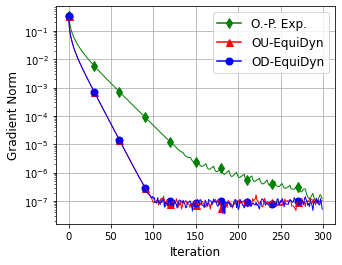

In [31]:
# plot the result
plt.rcParams['figure.figsize'] = 5, 4

plt.figure()
xlen = maxite

plt.semilogy(0, record_exp[0], color='green', marker='d', markersize = 7)
plt.semilogy(0, record_undi[0], color='red', marker='^', markersize = 7)
plt.semilogy(0, record_di[0], color='blue', marker='o', markersize = 7)

idx_set = np.arange(0, xlen, xlen//10)
plt.semilogy(idx_set, record_exp[idx_set], color='green', marker='d', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, record_undi[idx_set], color='red', marker='^', markersize = 7, linestyle = 'None')
plt.semilogy(idx_set, record_di[idx_set], color='blue', marker='o', markersize = 7, linestyle = 'None')

plt.semilogy(np.arange(xlen), record_exp, linewidth=1.0, color='green')
plt.semilogy(np.arange(xlen), record_undi, linewidth=1.0, color='red')
plt.semilogy(np.arange(xlen), record_di, linewidth=1.0, color='blue')

plt.legend(['O.-P. Exp.', 'OU-EquiDyn', 'OD-EquiDyn'], fontsize=12)
plt.xlabel('Iteration', fontsize = 12)
plt.ylabel('Gradient Norm', fontsize = 12)
plt.grid(True)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()